# 1 Resumo do pedido


Você trabalha em uma startup que vende produtos alimentícios. Você precisa analisar o comportamento do usuário para o aplicativo da empresa.

Primeiro estude o funil de vendas. Descubra como os usuários chegam à etapa de compra.Quantos usuários realmente chegam a essa etapa? Quantos ficam presos nas fases anteriores? Quais etapas em particular?

Em seguida, veja os resultados do teste A/A/B. (Continue lendo para obter mais informação sobre os testes A/A/B.) Os designers gostariam de alterar as fontes de todo o aplicativo, mas os gerentes temem que os usuários achem o novo design intimidador. Eles decidem tomar a decisão com base nos resultados de um teste A/A/B.

Os usuários são divididos em três grupos: dois grupos de controle recebem as fontes antigas e um grupo de teste recebe as novas. Descubra qual conjunto de fontes produz melhores resultados

A criação de dois grupos A tem certas vantagens. Podemos adaptar um princípio segundo o qual só estaremos confiantes na precisão de nossos testes quando os dois grupos de controle forem semelhantes. Se houver diferenças significativas entre os grupos A, isso pode nos ajudar a descobrir fatores que podem distorcer os resultados. A comparação de grupos de controle também nos informa de quanto tempo e dados precisaremos ao executar outros testes.

Você usará o mesmo conjunto de dados para análise geral e análise A/A/B. Em projetos reais, os experimentos se realizam constantemente. Os analistas estudam a qualidade de um aplicativo usando dados gerais, sem prestar atenção na participação dos usuários de experimentos.

# 1.1 Carregando bibliotecas necessárias

In [168]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotly import graph_objs as go


# 1.2 Carregando dados fornecidos

In [169]:
logs_data = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')


In [170]:
logs_data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


# 2 Pré-processamento dos dados

Vou agora checar se os dados precisam ser processados. Checar possíveis problemas em cada coluna, valores ausentes e duplicatas, e processar os dados pra facilitar a análise adiante.

# 2.1 Análises Iniciais

In [171]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [172]:
logs_data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [173]:
logs_data.duplicated().sum()

413

Resultados da análise inicial:
    
    1) As colunas estão todas em UpperCase. Vou modificar os nomes de todas pra letras minúsculas e adicionar um "_" em todas. 
    2) A coluna EventTimestamp está em tipo Int, e deveria estar em tipo datetime. Vou realizar a conversão
    3) Encontrei 413 linhas duplicadas no dataset. Vou investigá-las e tomar uma decisão do que fazer com elas
    4) As colunas "EventName" e "ExpId" são colunas categóricas. Desse modo, eu posso agrupá-las de um modo mais eficaz pra visualização. Vou criar categorias novas e agrupar esses valores nas categorias.

# 2.1.1 Modificando os nomes das colunas

In [174]:
logs_data = logs_data.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_time_stamp',
    'ExpId': 'exp_id'})
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   device_id_hash    244126 non-null  int64 
 2   event_time_stamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# 2.1.2 Convertendo para datetime

In [175]:
logs_data['datetime'] = pd.to_datetime(logs_data['event_time_stamp'], unit = 's')
logs_data['date'] = pd.to_datetime(logs_data['datetime'].dt.date)


In [176]:
logs_data.head()

,event_name,device_id_hash,event_time_stamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [177]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  int64         
 2   event_time_stamp  244126 non-null  int64         
 3   exp_id            244126 non-null  int64         
 4   datetime          244126 non-null  datetime64[ns]
 5   date              244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


O formato da coluna "event_time_stamp" estava em Unix timestamp. Adicionei uma coluna extra com as datas convertidas no formato tradicional de horário e data.

# 2.1.3 Checando duplicatas

Vou agora checar como são essas linhas duplicadas.

In [178]:
logs_data.duplicated().value_counts()

False    243713
True        413
dtype: int64

In [179]:
logs_data[logs_data.duplicated()].value_counts()

event_name               device_id_hash       event_time_stamp  exp_id  datetime             date      
Tutorial                 3473691793382022823  1564697509        248     2019-08-01 22:11:49  2019-08-01    4
PaymentScreenSuccessful  4980045449118619005  1564665640        247     2019-08-01 13:20:40  2019-08-01    4
Tutorial                 3473691793382022823  1564697513        248     2019-08-01 22:11:53  2019-08-01    4
PaymentScreenSuccessful  636437379427729086   1564726206        247     2019-08-02 06:10:06  2019-08-02    4
                                              1564726205        247     2019-08-02 06:10:05  2019-08-02    3
                                                                                                          ..
MainScreenAppear         4841344099510929469  1565192803        248     2019-08-07 15:46:43  2019-08-07    1
                         4696345510646727891  1565171323        248     2019-08-07 09:48:43  2019-08-07    1
                        

A quantidade de linhas iguais é muito váriavel. Existem linhas que aparecem 4 vezes, enquanto existem linhas que aparecem uma vez (na sua grande maioria). Como a proporção de dados duplicados é baixa em relação ao total, posso excluir esses dados sem afetar negativamente a nossa análise.

In [180]:
logs_data = logs_data.drop_duplicates()
logs_data.duplicated().sum()

0

# 2.1.4 Agrupando Categorias

Vou checar quais são os tipos de evento que são possiveis, e quantos usuários existem em cada evento e em cada grupo.

In [181]:
logs_data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [182]:
logs_data['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

A categorização já está boa em ambos os casos. Somente pra melhorar a visualização eu vou substituir os valores dos grupos. 
246 e 247 são grupo controle, vou modifica-los pra A1 e A2 respectivamente, e 248 vou modificar para B.

In [183]:
logs_data['exp_id'] = logs_data['exp_id'].replace({246: 'A1', 247: 'A2', 248: 'B'})
logs_data['exp_id'].value_counts()

B     85582
A1    80181
A2    77950
Name: exp_id, dtype: int64

In [184]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        243713 non-null  object        
 1   device_id_hash    243713 non-null  int64         
 2   event_time_stamp  243713 non-null  int64         
 3   exp_id            243713 non-null  object        
 4   datetime          243713 non-null  datetime64[ns]
 5   date              243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


# 3 Estudando os Dados

Com os dados preparados, vou agora estudar as informações deles. Quantos tipos de eventos temos (já chequei, mas vou me aprofundar neles com mais calma), número de usuários, número médios de usuário por eventos, horários de acesso, etc.

In [185]:
logs_data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Esse é o funil de acesso dos usuários. Com a ordem sendo "Tela principal aparece" > "Tela de ofertas" > "Tela do Carrinho" > "Tela de Sucesso no Pagamento". No entanto, temos 1018 acessos em Tutorial. Isso parece ser uma seção à parte que não deve ser levada em conta no funil. Provavelmente alguns usuários se sentiram confusos com o processo em algum momento e sentiram a necessidade de consultar o tutorial. Vamos checar à qual grupo esses usuários pertencem:

In [186]:
logs_data[logs_data['event_name'] == 'Tutorial']['exp_id'].value_counts().reset_index()


,index,exp_id
0,B,355
1,A2,345
2,A1,318


A diferença é muito pouca, mas podemos ver que o grupo B foi o grupo que mais acessou o Tutorial. Isso pode ter relação com as mudanças feitas nas fontes.

Voltando aos valores principais, podemos visualizar melhor usando um gráfico.

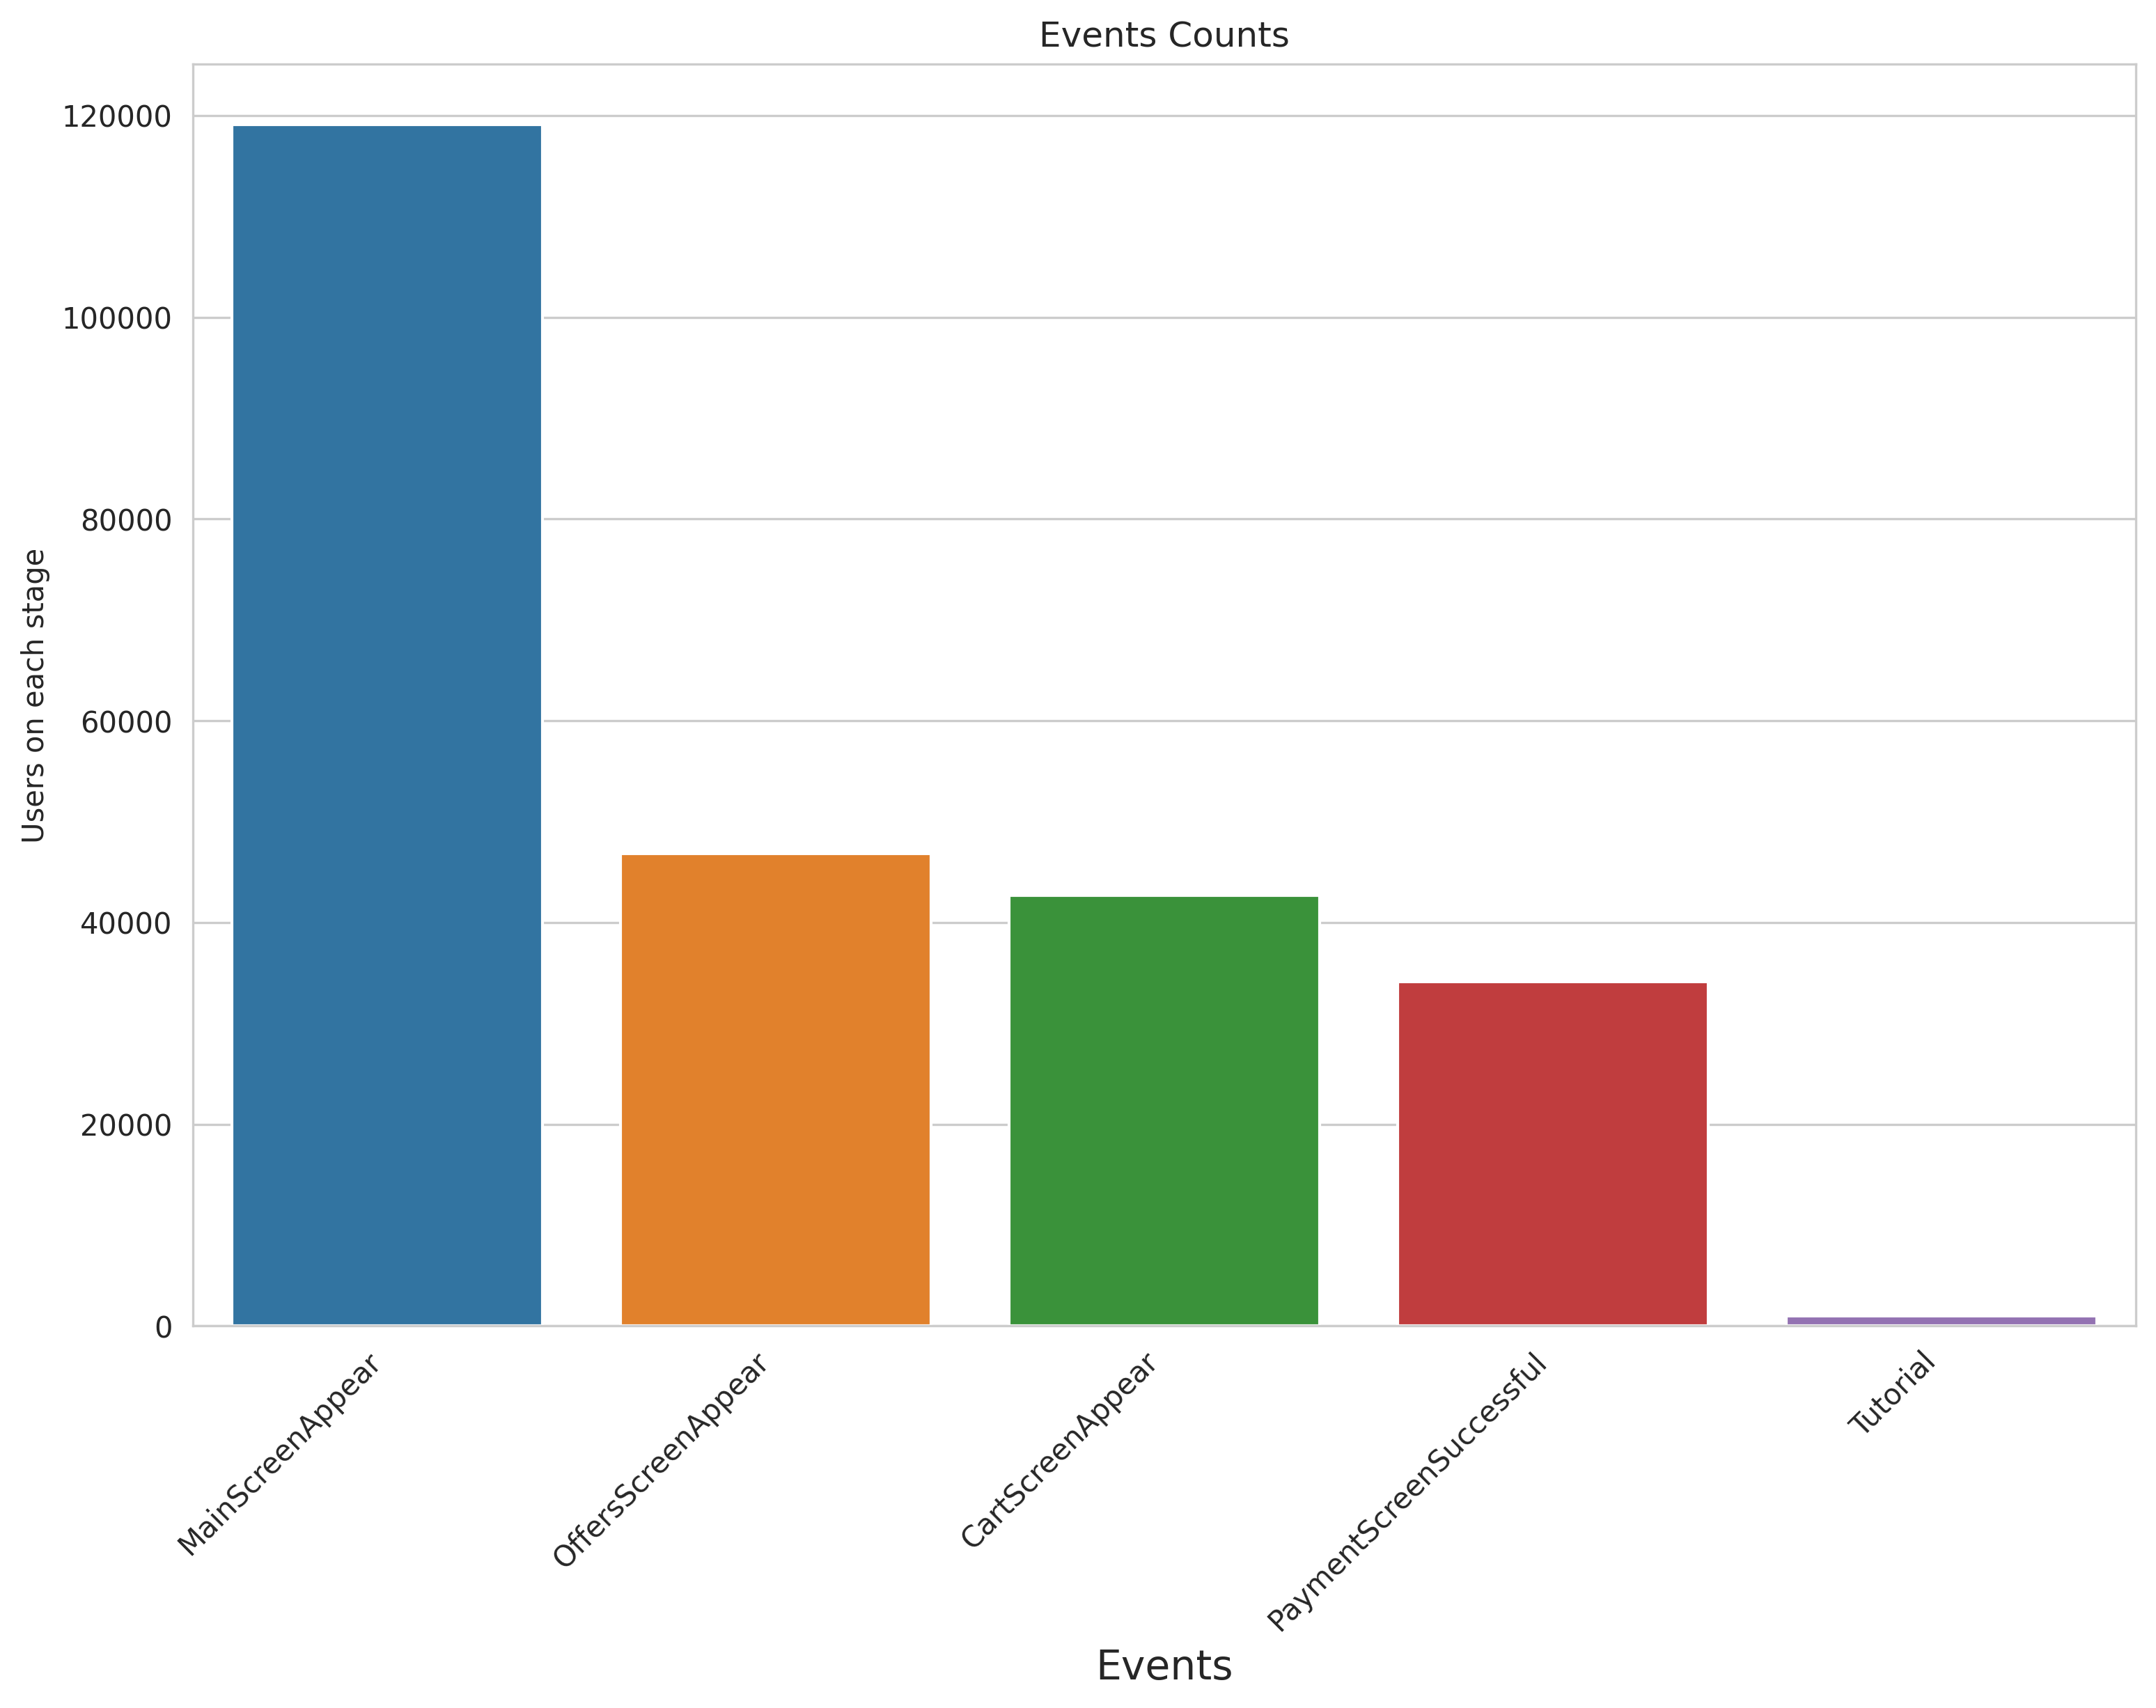

In [187]:
events_counts = (logs_data['event_name'].value_counts())

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8), dpi = 300)
sns.barplot(x=events_counts.index, y=events_counts.values)
plt.title('Events Counts')
plt.xlabel('Events', fontsize = 14)
plt.ylabel('Users on each stage')
plt.xticks(rotation=45, ha='right') 
plt.show()

Existe uma queda muito brusca entre a tela principal e a tela de ofertas. A queda de usuários vai de aproximadamente 120 mil para quase 45 mil. É quase 33% dos acessos apenas. Nos passos 2, 3 e 4 existe uma queda muito menos brusca. 

Vou investigar se essa queda é igual em todos os grupos.

In [188]:
print(logs_data[logs_data['event_name'] == 'MainScreenAppear']['exp_id'].value_counts().reset_index())
print(logs_data[logs_data['event_name'] == 'OffersScreenAppear']['exp_id'].value_counts().reset_index())

  index  exp_id
0     B   41175
1    A2   39677
2    A1   38249
  index  exp_id
0     B   16563
1    A2   15341
2    A1   14904


Sim, a queda é idêntica em todos grupos. Vou plotar apenas pra melhor visualização.

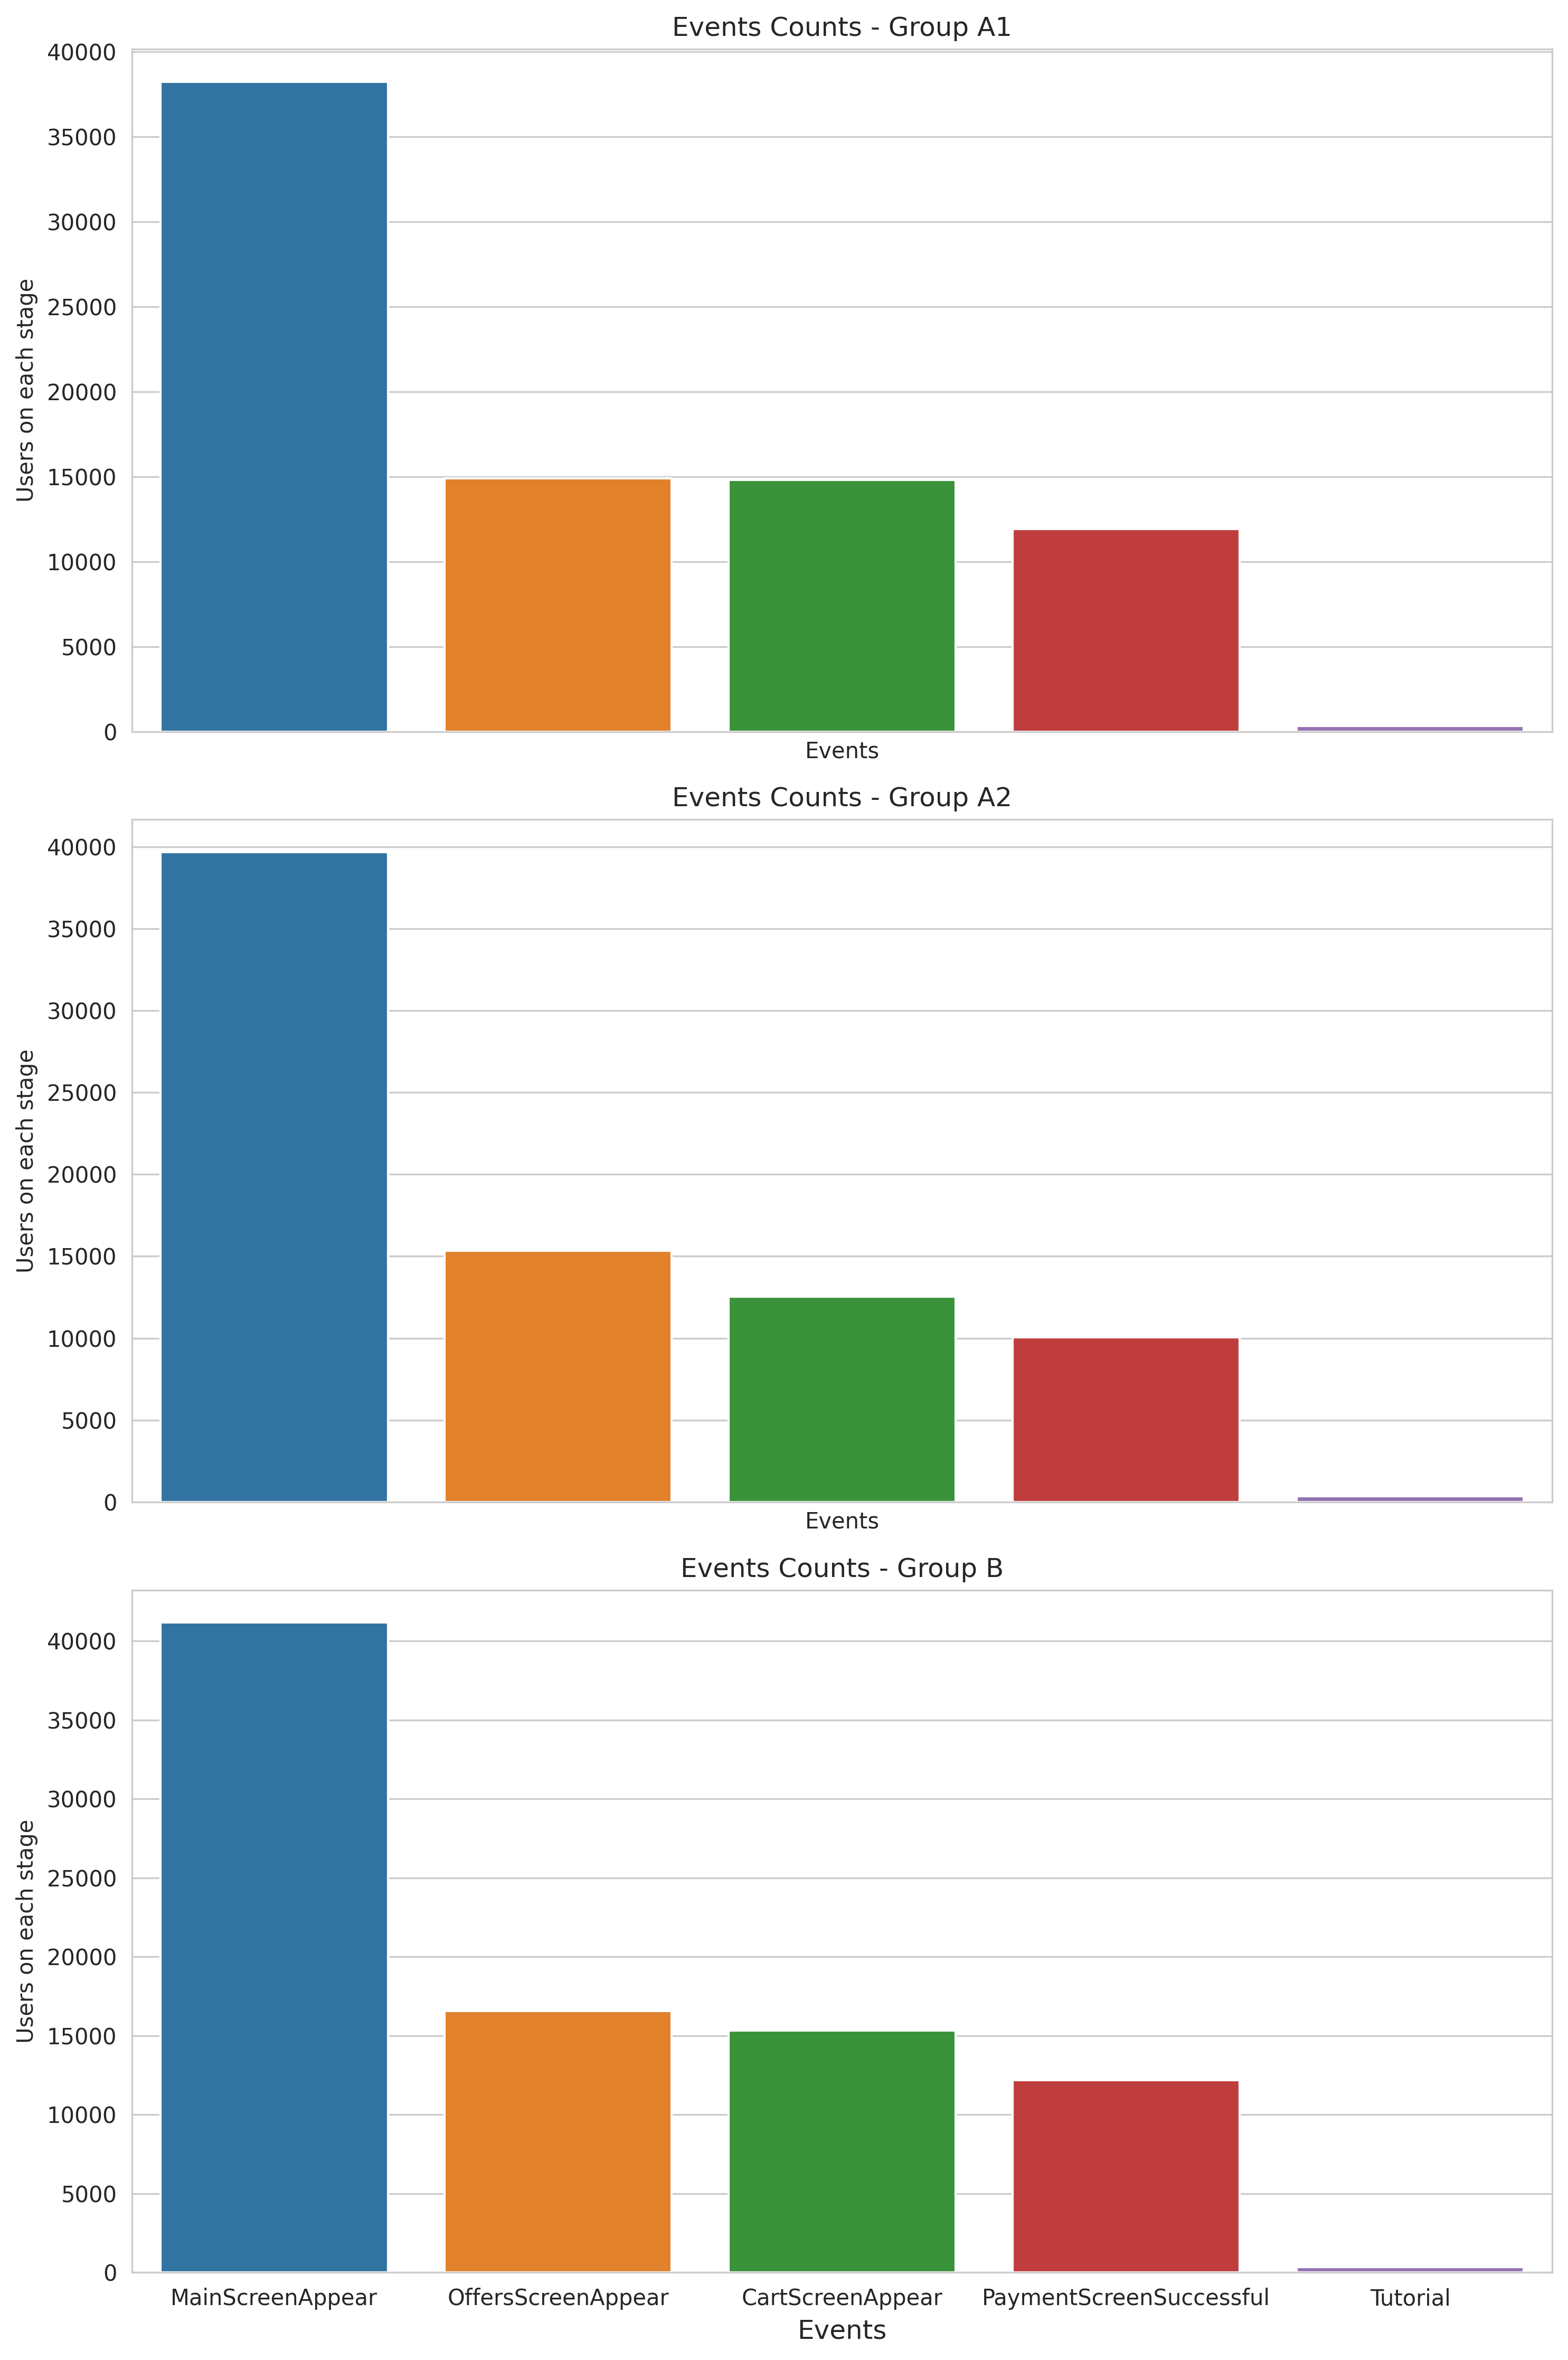

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi = 300, sharex=True)

data_A1 = logs_data[logs_data['exp_id'] == 'A1']
data_A2 = logs_data[logs_data['exp_id'] == 'A2']
data_B = logs_data[logs_data['exp_id'] == 'B']

sns.countplot(data=data_A1, x='event_name', order=data_A1['event_name'].value_counts().index, ax=ax1)
ax1.set_title('Events Counts - Group A1')
ax1.set_xlabel('Events')
ax1.set_ylabel('Users on each stage')


sns.countplot(data=data_A2, x='event_name', order=data_A2['event_name'].value_counts().index, ax=ax2)
ax2.set_title('Events Counts - Group A2')
ax2.set_xlabel('Events')
ax2.set_ylabel('Users on each stage')


sns.countplot(data=data_B, x='event_name', order=data_B['event_name'].value_counts().index, ax=ax3)
ax3.set_title('Events Counts - Group B')
ax3.set_xlabel('Events', fontsize=12)
ax3.set_ylabel('Users on each stage')


plt.tight_layout()
plt.show()


Percebemos que o padrão segue em todos grupos. Além disso, também é interessante notar que no Grupo A1 existe a menor discrepância entre o Evento de Ofertas e o Evento de Carrinho. Podemos analisar isso mais adiante.

Vou checar agora o numéro médio de eventos por usuário.

In [190]:
logs_data.groupby('device_id_hash')['event_name'].count().mean()

32.27559263673685

Esse é o número médio de eventos por usuário, que é uma métrica que pode indicar o engajamento e a experiência do usuário. 

Se a média de eventos por usuário é de aproximadamente 32, vemos que muitos usuários passam pelo mesmo evento várias vezes, enquanto outros podem não estar gerando poucos.

Vou realizar agora uma análise temporal dos dados, verificando a abrangência de tempo que os dados possuem.

Primeiro, vou encontrar a data miníma e máxima.

In [191]:
print(logs_data['datetime'].min())
print(logs_data['datetime'].max())


2019-07-25 04:43:36
2019-08-07 21:15:17


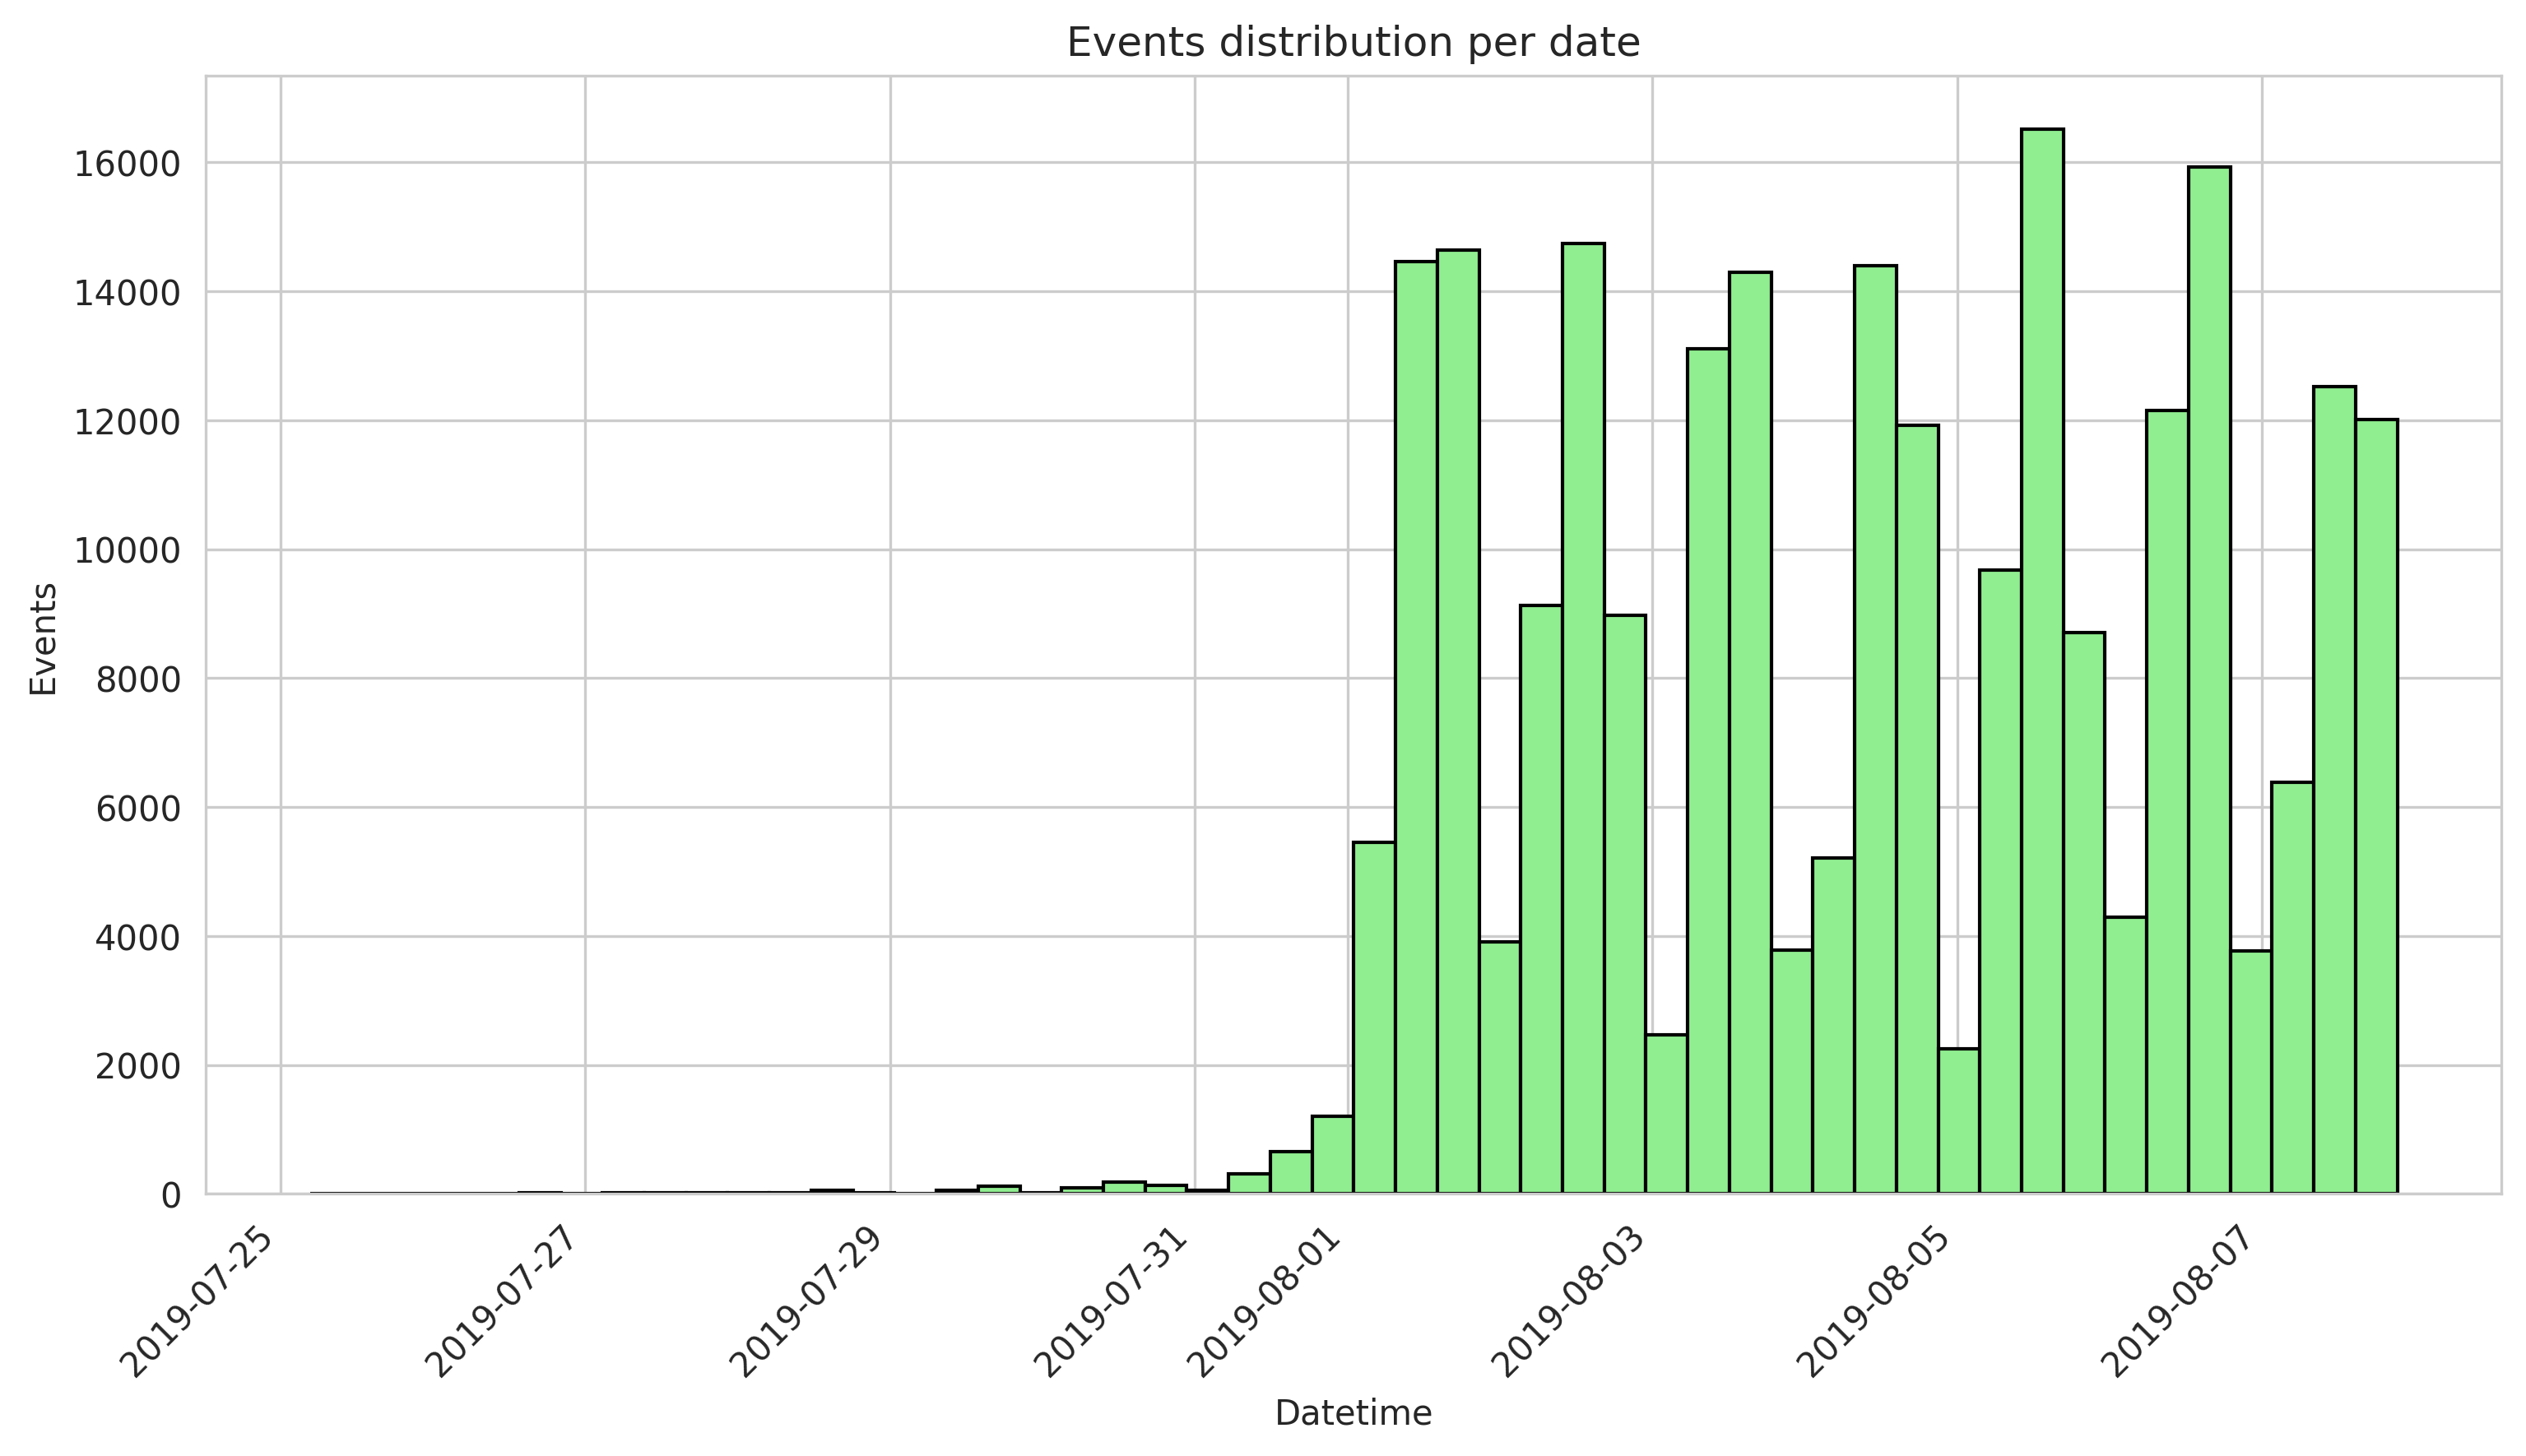

In [192]:
plt.figure(figsize=(12, 6), dpi = 300)

logs_data['datetime'].hist(bins=50, color='lightgreen', edgecolor='black')

plt.title('Events distribution per date')
plt.xlabel('Datetime')
plt.ylabel('Events')
plt.xticks(rotation=45, ha='right') 

plt.show()


Podemos ver que, apesar do nosso primeiro registro ser no dia 25/07, não tivemos ocorrências significativas antes do dia 01/08. Se mantivermos esses dados antes desta data teremos um problema impactante no nosso resultado final, que vai desviar completamente o viés da análise.

Vou então remover todos os dados anteriores ao dia 01/08 e manter somente os dados à partir desta data.

In [193]:
logs_data_filtered = logs_data[logs_data['date'] >= '2019-08-01']
print(logs_data_filtered['datetime'].min())
print(logs_data_filtered['datetime'].max())

2019-08-01 00:07:28
2019-08-07 21:15:17


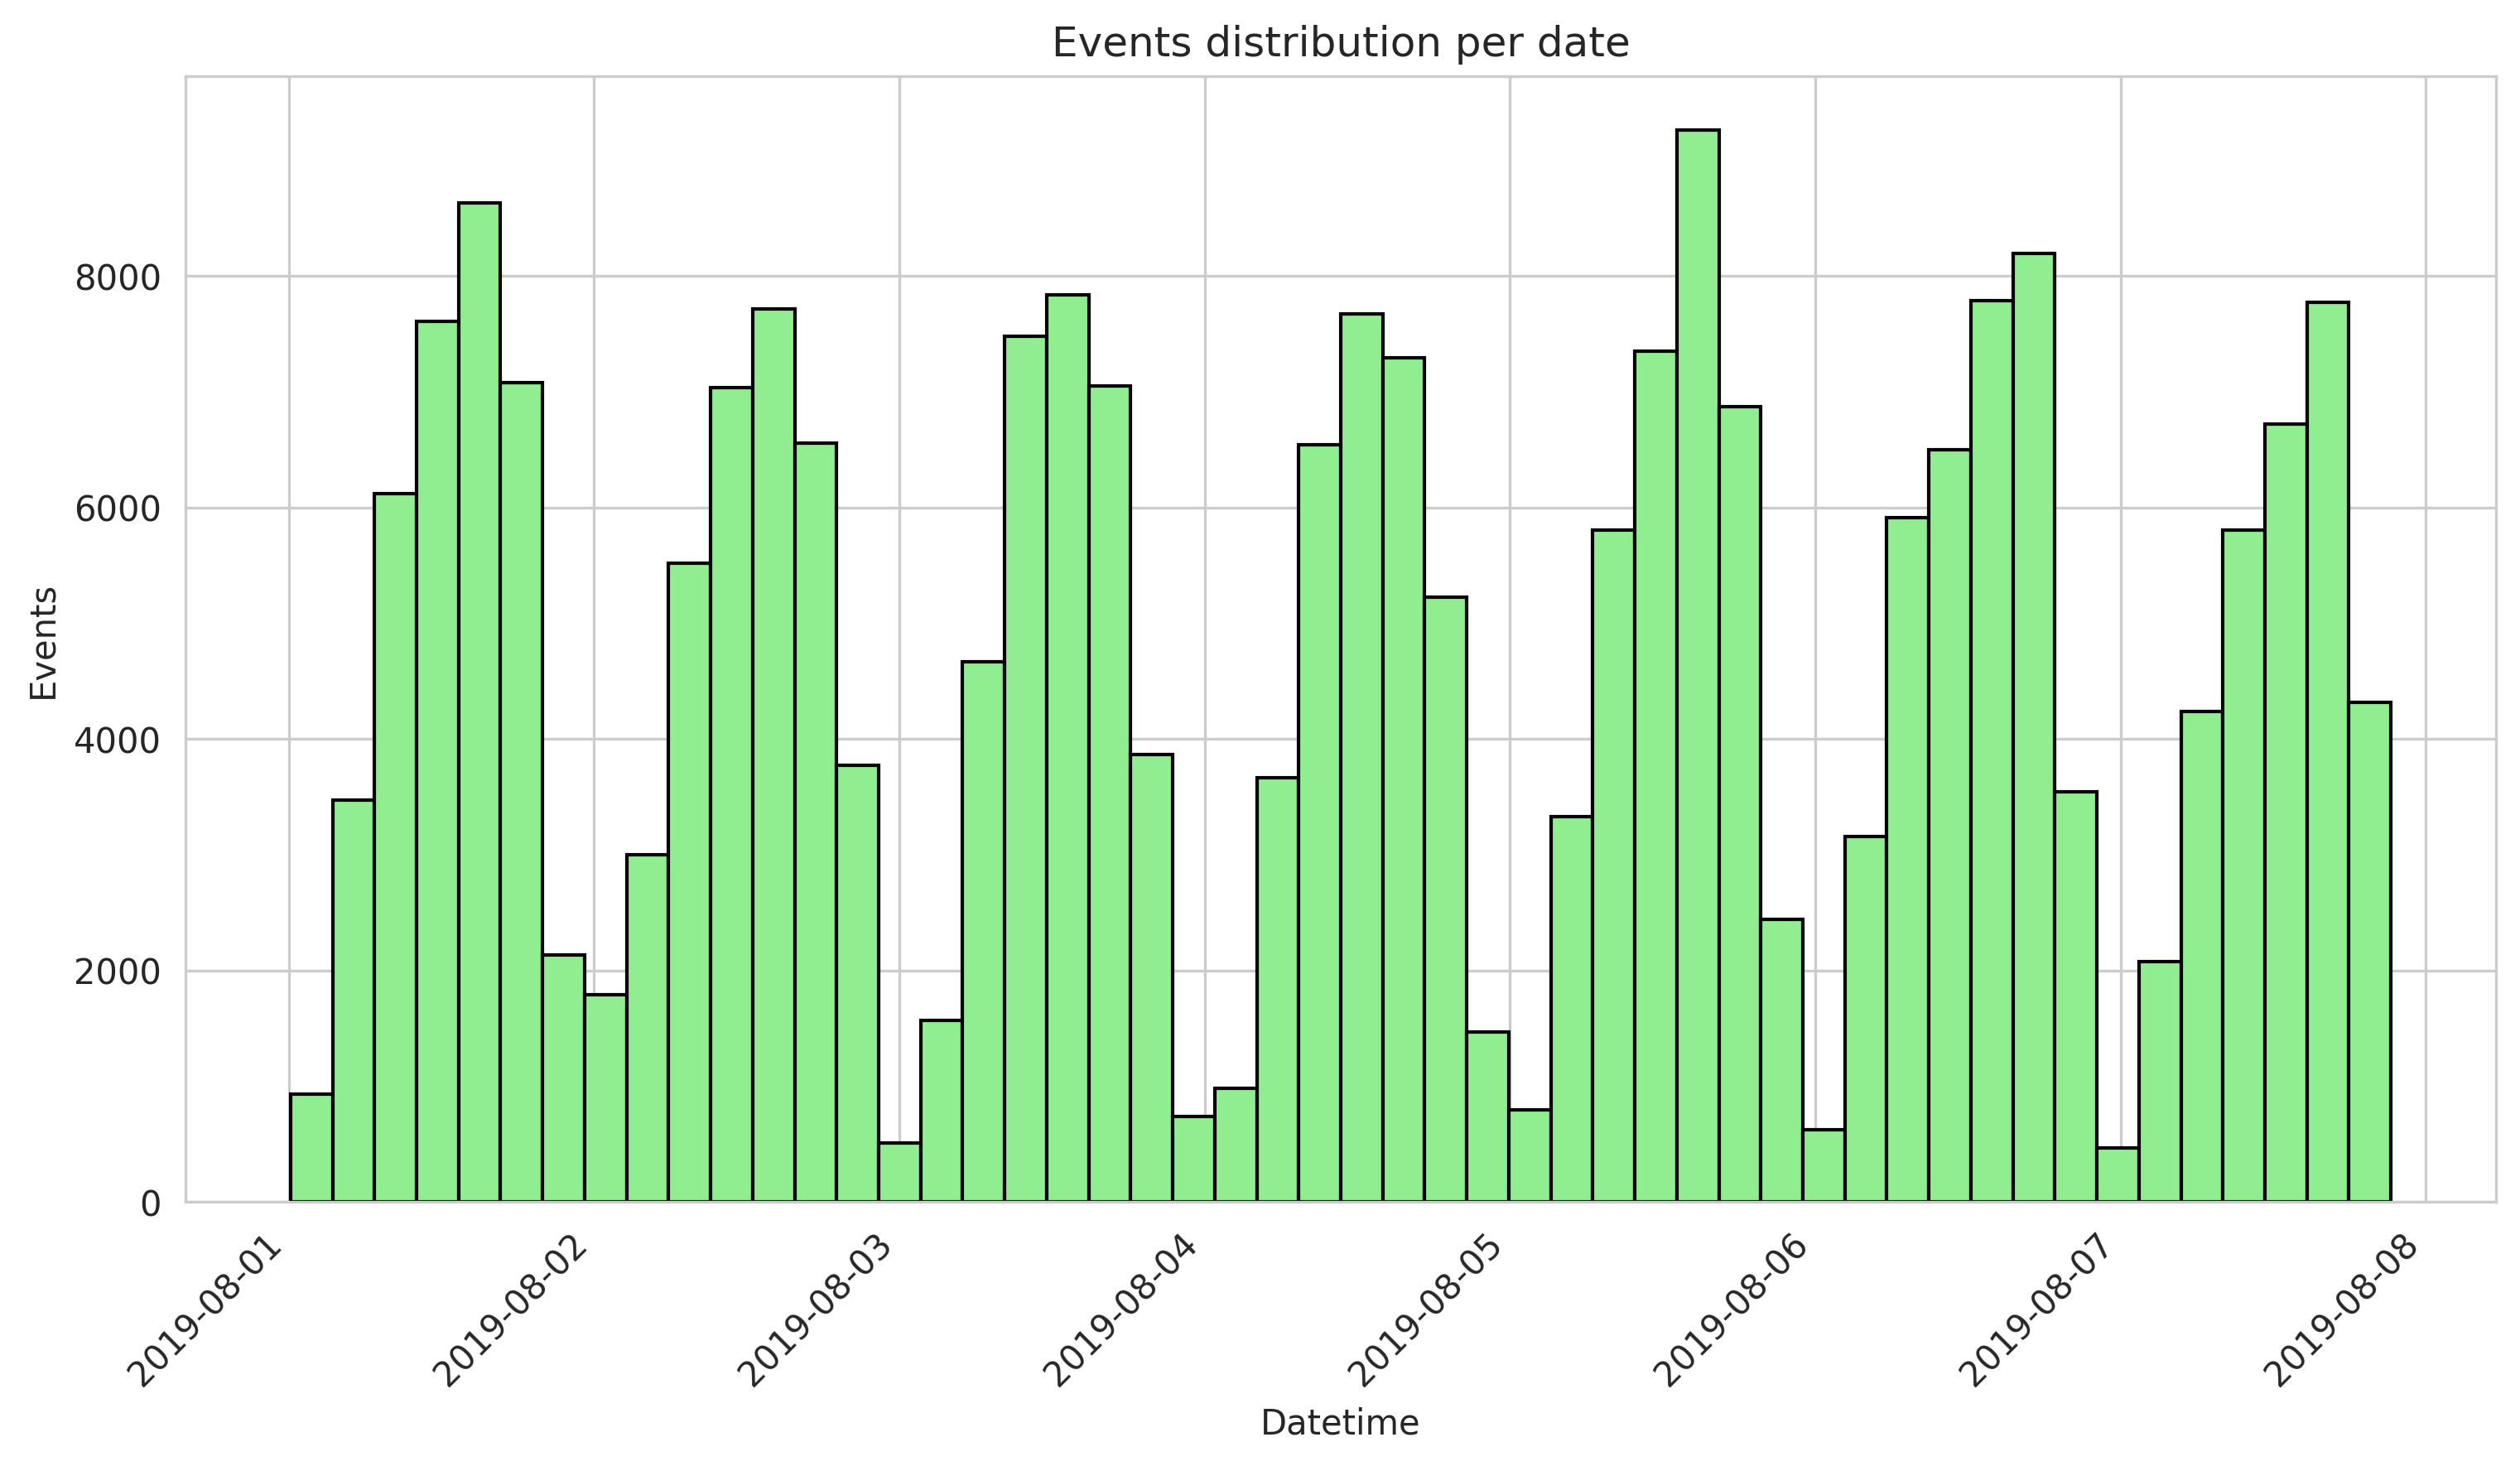

In [194]:
plt.figure(figsize=(12, 6), dpi = 300)

logs_data_filtered['datetime'].hist(bins=50, color='lightgreen', edgecolor='black')

plt.title('Events distribution per date')
plt.xlabel('Datetime')
plt.ylabel('Events')
plt.xticks(rotation=45, ha='right') 

plt.show()

Agora sim nossa visualização está bem estruturada, mas vamos confirmar se perdermos uma parcela significativa dos nossos dados.

In [195]:
print(logs_data['device_id_hash'].value_counts().sum())
print(logs_data_filtered['device_id_hash'].value_counts().sum())

243713
240887


Perdemos cerca de 3000 linhas, pouco mais de 1% dos nossos dados. Não é uma perda significativa, mas ainda assim eles causariam um problema na análise final.

Vamos confirmar também a quantidade de usuários de cada grupo.

In [196]:
print(logs_data['exp_id'].value_counts())
print(logs_data_filtered['exp_id'].value_counts())

B     85582
A1    80181
A2    77950
Name: exp_id, dtype: int64
B     84563
A1    79302
A2    77022
Name: exp_id, dtype: int64


Mantivemos uma boa quantidade de usuários em cada grupo.

# 4 Estudando o Funil

Vou agora analisar o funil de eventos. Como é a sequência dos acontecimentos? Como se mantém a proporção dentro do funil? O que explica as etapas onde se perdem muitos clientes?

Primeiro, vamos visualizar novamente quantas pessoas passam por cada etapa e analisar elas individualmente:

In [197]:
logs_data_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

MainScreenAppear: tela inicial. Faz sentido ser o evento mais comum. 117328 clientes então podem representar o total que fizeram o acesso, pois todos precisam OBRIGATORIAMENTE acessar a tela inicial. É um fator importante que pode ser levado em conta se for realizada uma análise de chegada por anúncios ou métricas semelhantes.

OffersScreenAppear: tela de oferta. Esse é o evento que possui a maior queda de clientes. Ocorre uma perda de quase 1/3 do total de acessos, e é um fenômeno que merece uma atenção mais detalhada.

CartScreenAppear: tela do carrinho de compras. Não existe uma perda muito significativa aqui, o que indica que uma grande parcela dos clientes que checaram as ofertas adicionaram alguns itens aos seus carrinhos.

PaymentScreenSuccessful: tela de pagamento bem-sucedido. Existe uma perda de aproximadamente 10 mil clientes entre o carrinho e o pagamento bem-sucedido. É necessário descobrir o motivo dessa perda significativa. Pode ser que esteja acontecendo algum bug na hora de inserir os dados, ou então o processo para adicionar o cartão de crédito pode ser muito longo e os clientes perdem a paciência.

Tutorial: conforme dito anteriormente, o tutorial não faz parte direta do funil. Existem acessos por motivos de dificuldade com a plataforma.

Vou analisar agora quantos usuários únicos realizaram cada uma dessas ações.

In [198]:
(logs_data_filtered.groupby('event_name', as_index=False)
                  .agg({'device_id_hash':'nunique'})
                  .sort_values(by='device_id_hash', ascending=False))


,event_name,device_id_hash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


A quantidade de acessos manteve a mesma ordem proporcional que para os IDs não-únicos. Podemos encontrar algumas informações interessantes que modificam nossa visão em relação à primeira análise:

    - Existe uma diminuição proporcional menor entre os eventos "MainScreenAppear" e "OffersScreenAppear" agora. Se a proporção fosse a mesma, então teríamos que ter aproximadamente 1/3 dos acessos de OffersScreenAppear em comparação com o primeiro evento. Porém a proporção é de aproximadamente 62%, quase 2/3! Então isso mostra que existem muitos acessos repetidos na seção principal. Provavelmente os usuários voltam ao menu principal constantemente, e isso faz com que o número de acessos fique enviesado e pareça que esteja acontecendo uma perda significativa de interesse.
    
    - A mudança na quantidade de acessos na seção de Tutorial foi minima em proporção com a quantidade total de dados. É seguro afirmar que é um resultado lógico, pois dificilmente um usuário precisa retornar ao tutorial uma segunda vez.
    
    - A ordem de decaimento das outras categorias se mantiveram iguais, porém a proporção mudou. Agora a seção do carrinho para o pagamento está muito mais próxima. Provavelmente usuários que adicionam coisas no carrinho acabam voltando aos outros menus anteriores para adicionar mais ofertas ou então checar algum preço. Isso infla a quantidade de acessos na tela do carrinho e passa a impressão que existe algum bug ou problema no pagamento. Podemos ficar seguros que não é o caso aqui.

Tendo a visão da análise geral e análise única, podemos assumir que conhecemos a ordem dos eventos. A ordem decrescente dos eventos mostra que existe passos que os clientes seguem no acesso, e uma etapa leva à outra, então o funil de eventos fica:

    - MainScreenAppear > OffersScreenAppear > CartScreenAppear > PaymentScreenSuccessful. 
    - O Tutorial é um acesso separado e não faz parte do acesso do funil
    
Com isso, é possível agora visualizar exatamente as proporções e escoamento dos resultados dentro do funil de eventos.
Para isso, precisamos encontrar exatamente a quantidade de usuários que passam por cada etapa.

In [199]:
time_users_acess = logs_data_filtered.pivot_table(index='device_id_hash', columns='event_name', values='datetime', aggfunc='min')
time_users_acess

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id_hash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT
...,...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57,NaT
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16,NaT
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT,NaT


In [269]:
condition_main_screen = time_users_acess['MainScreenAppear'].notnull()
condition_offers_screen = condition_main_screen & time_users_acess['OffersScreenAppear'].notnull()
condition_cart_screen = condition_offers_screen & time_users_acess['CartScreenAppear'].notnull()
condition_payment_screen = condition_cart_screen & time_users_acess['PaymentScreenSuccessful'].notnull()

users_main_screen = time_users_acess[condition_main_screen].shape[0]
users_offers_screen = time_users_acess[condition_offers_screen].shape[0]
users_cart_screen = time_users_acess[condition_cart_screen].shape[0]
users_payment_screen = time_users_acess[condition_payment_screen].shape[0]

stages = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
users = [7419, 4482, 3580, 3429]
funnel_table = pd.DataFrame({"stages": stages, "users": users})
funnel_table

,stages,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4482
2,CartScreenAppear,3580
3,PaymentScreenSuccessful,3429


Vamos comparar com os dados que obtivemos anteriormente:

In [201]:
(logs_data_filtered.groupby('event_name', as_index=False)
                  .agg({'device_id_hash':'nunique'})
                  .sort_values(by='device_id_hash', ascending=False))

,event_name,device_id_hash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Quando levamos em consideração uma sequencia específica de eventos obtemos um resultado final diferente. Existe uma redução em todas etapas do funil, com exceção da primeira "MainScreenAppear". Isso mostra que dependendo da sequência analisada podemos ter resultados conflitantes, por isso é importante escolher sabiamente a sequência lógica mais viável. Obviamente isso não impede que outras sequências também sejam possíveis, e dependendo da análise feita teremos cada fatia com um impacto diferente no resultado final.

Encontrando as proporções de cada fase:

In [202]:
main_to_offers_conversion = (users_offers_screen / users_main_screen) * 100
offers_to_cart_conversion = (users_cart_screen / users_offers_screen) * 100
cart_to_payment_conversion = (users_payment_screen / users_cart_screen) * 100

print(f"Conversion rate from MainScreenAppear to OffersScreenAppear: {main_to_offers_conversion:.2f}%")
print(f"Conversion rate from OffersScreenAppear to CartScreenAppear: {offers_to_cart_conversion:.2f}%")
print(f"Conversion rate from CartScreenAppear to PaymentScreenSuccessful: {cart_to_payment_conversion:.2f}%")

Conversion rate from MainScreenAppear to OffersScreenAppear: 60.41%
Conversion rate from OffersScreenAppear to CartScreenAppear: 79.88%
Conversion rate from CartScreenAppear to PaymentScreenSuccessful: 95.78%


Essas são as taxas de conversões. Incrivelmente temos uma taxa de conversão de 95% em uma das etapas, que é evidentemente muito alta. Vamos mantê-la por enquanto, mas ela pode ser um indicativo que talvez a ordem selecionada não seja a correta.

Vemos também que a maior redução ocorre de "MainScreenAppear" para "OffersScreenAppear". Isso pode apontar que existe algum tipo de problema na tela principal que impede que os usuários acessem a tela de ofertas.

Por fim, podemos encontrar também a porcentagem de usuários que chegam até o fim do funil:

In [203]:
total_conversion_rate = (users_payment_screen/users_main_screen)*100
print(f"Total conversion rate: {total_conversion_rate:.2f}%")


Total conversion rate: 46.22%


Seguindo essa rota de funil, 46.22% dos acessos resultam em uma conversão positiva. 
É uma taxa de conversão MUITO significativa, com uma alta taxa de sucesso. Se esse não for o principal caminho do funil, seria interessante comparar com o cenário onde a tela de ofertas não faz parte do funil. Se o resultado for menor, é de se cogitar que os usuários passem pela tela de ofertas obrigatoriamente.

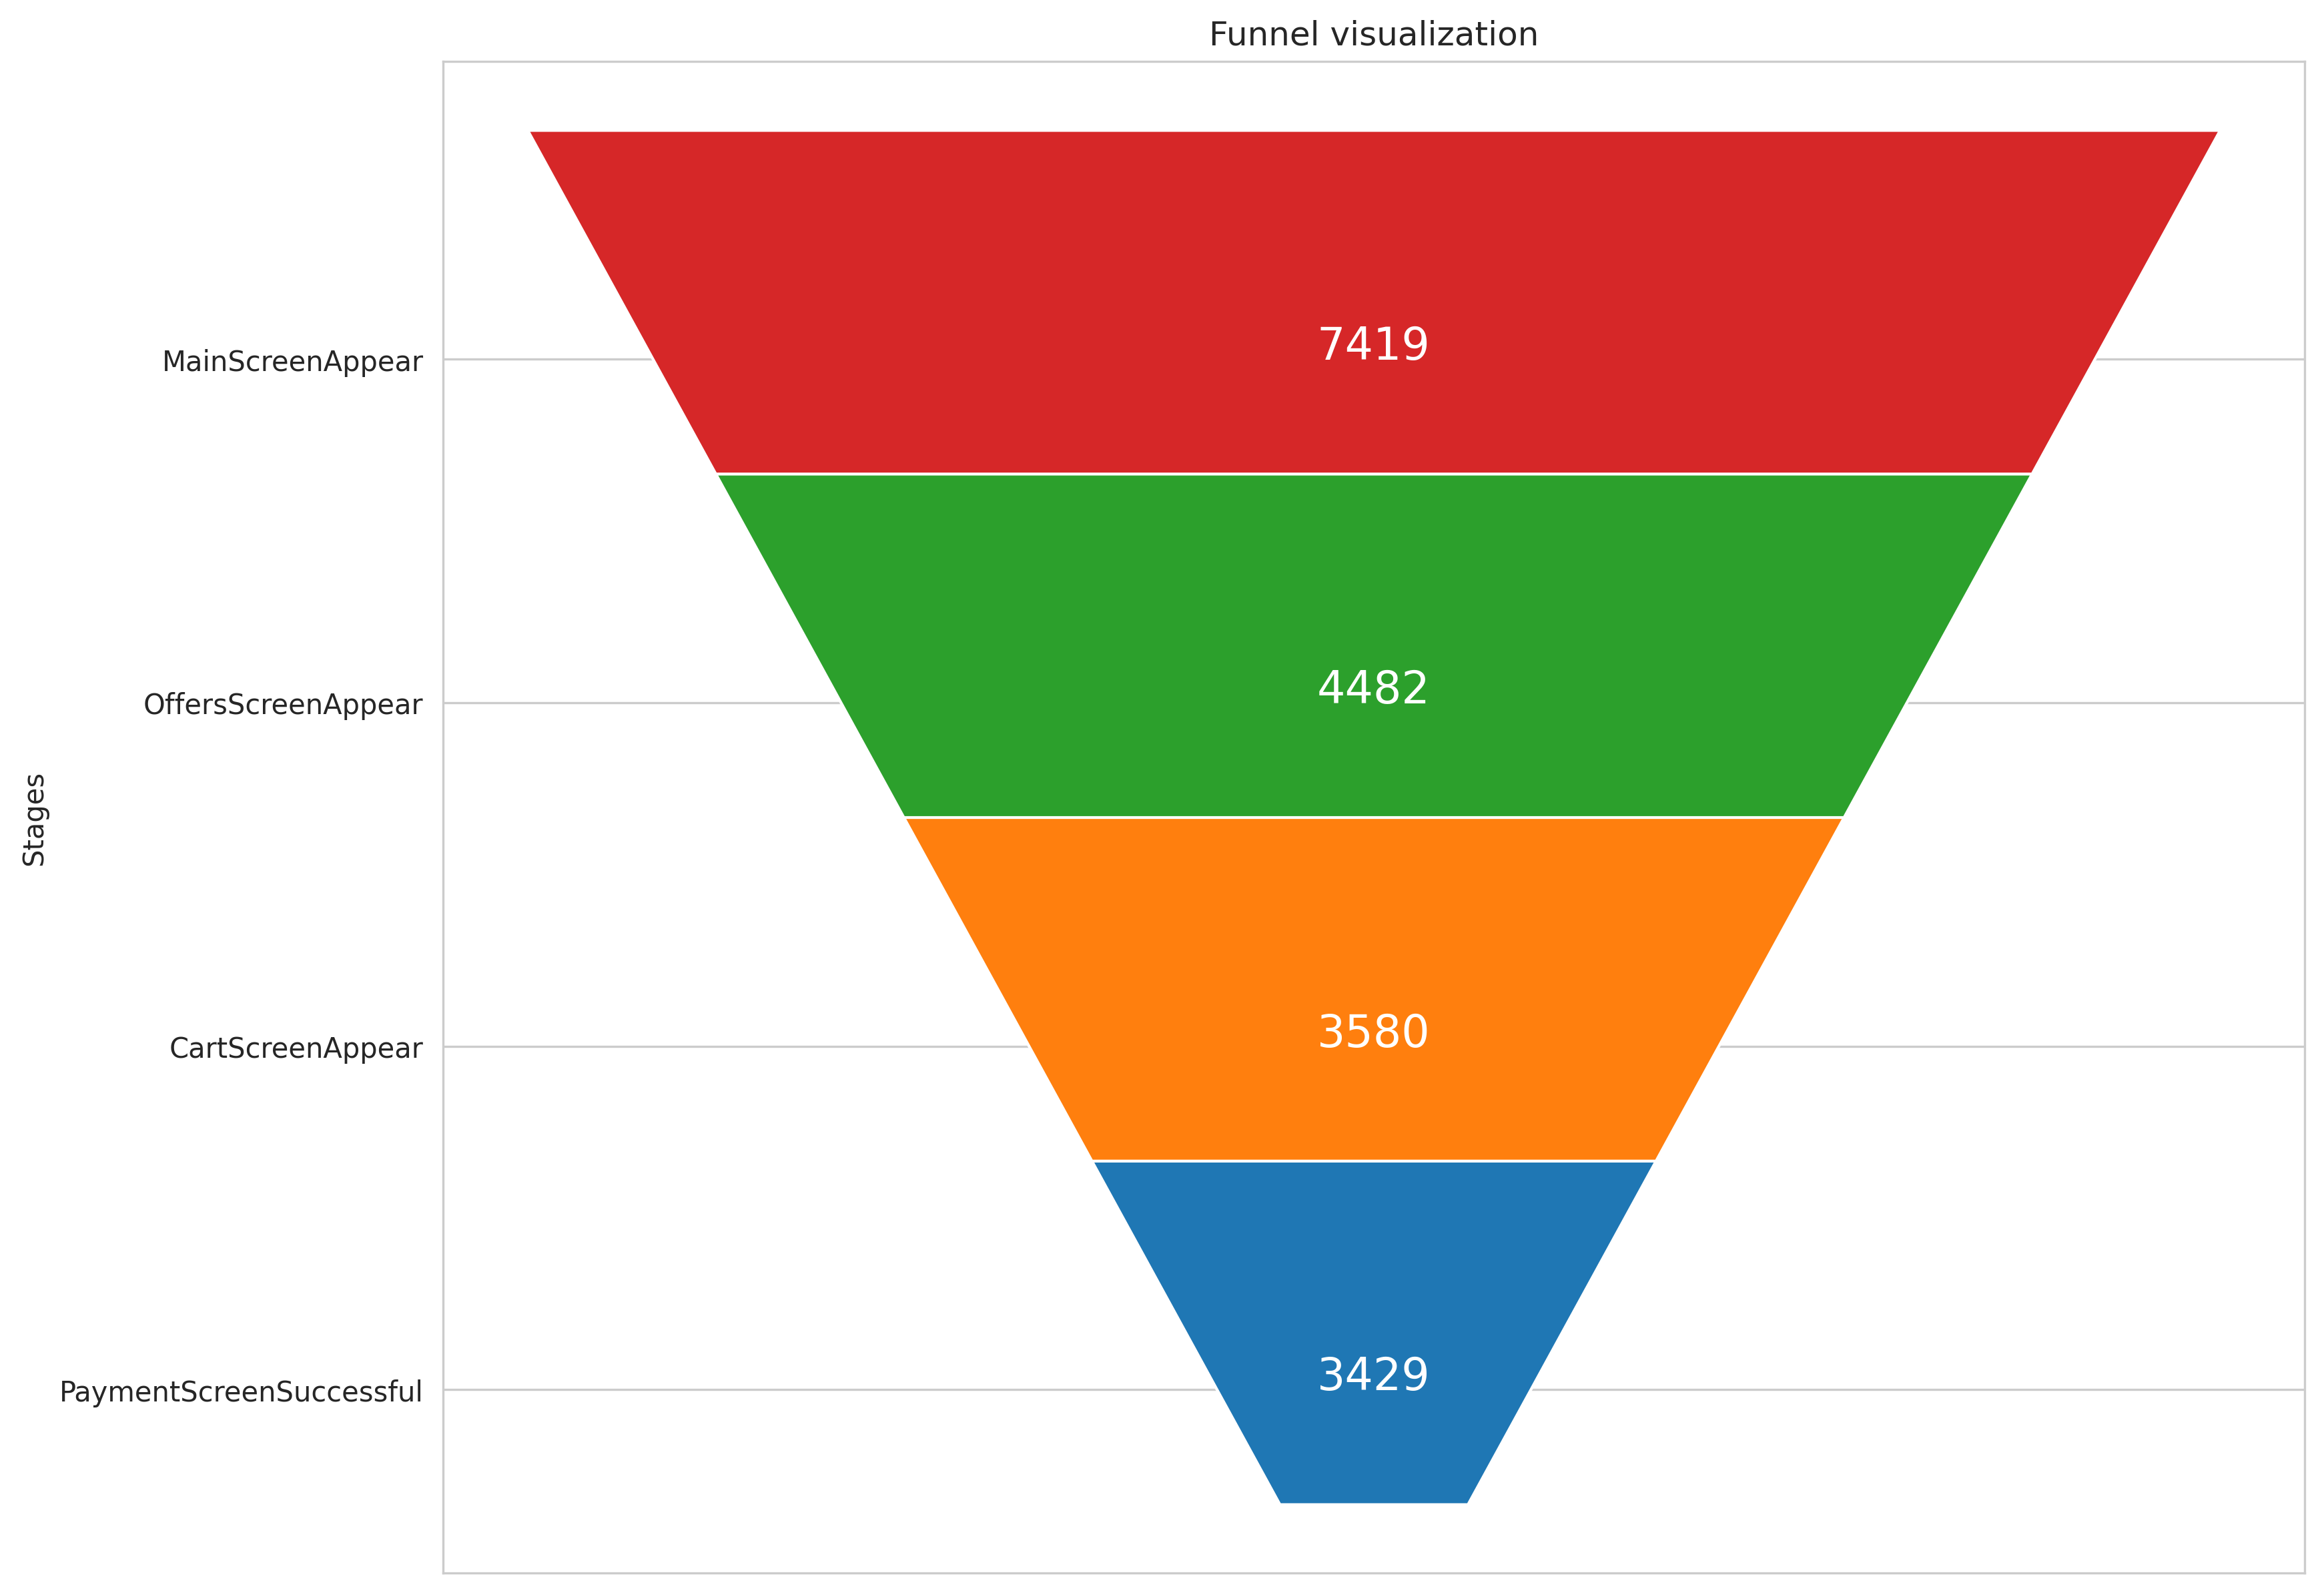

In [204]:
plt.figure(figsize=(12,10), dpi = 300)

plt.fill_betweenx(y=[1, 4], x1 = [10, 12], x2 = [8,6])
plt.fill_betweenx(y=[4, 7], x1 = [12, 14], x2 = [6,4])
plt.fill_betweenx(y=[7, 10], x1 = [14, 16], x2 = [4,2])
plt.fill_betweenx(y=[10, 13], x1 = [16, 18], x2 = [2,0])

plt.xticks([], [])
plt.yticks([2,5,8,11], funnel_table["stages"][::-1])
for y, value in zip([2, 5, 8, 11], funnel_table["users"][::-1]):
    plt.text(9, y, value, fontsize = 16, color = "white", ha = "center")
    
plt.ylabel("Stages")
plt.title("Funnel visualization")

plt.show()


A visualização fica melhor com o gráfico, e vemos o escoamento dos usuários no passar de cada etapa. Grande parte dos usuários que chegam na tela de carrinho efetuam a compra.

# 5 Resultados dos testes

Vou agora analisar o teste em si. Lembrando sobre o que se trata o experimento: temos 3 grupos, divididos em A/A/B. Os dois grupos A são grupos controle (chamei eles de A1 e A2) e o grupo B é o grupo teste. O grupo B foi submetido à um experimento onde ocorreu uma mudança na fonte do serviço, e estamos investigando o impacto dessa mudança.

Vamos verificar novamente quantos usuários temos em cada grupo:

In [205]:
logs_data_filtered['exp_id'].value_counts()

B     84563
A1    79302
A2    77022
Name: exp_id, dtype: int64

# 5.1 Diferença estatística entre o grupo A1 e A2

Como existem dois grupos A, precisamos encontrar se existe alguma diferença estatística entre esses dois grupos, para garantir a funcionalidade do experimento. Além disso, queremos encontrar os resultados estatísticos para clientes que efetuaram suas compras, então precisamos checar somente para usuários que atendem esse requisito.

Então as hipóteses para o teste são:

    - H0: não existe diferença estatística significativa entre as médias os grupos A1 e A2
    - H1: existe diferença estatística significativa entre as médias grupos A1 e A2
   

In [206]:
successful_data = logs_data_filtered[logs_data_filtered['event_name'] == 'PaymentScreenSuccessful'].reset_index(drop=True)

orders_A1 = successful_data[successful_data['exp_id'] == "A1"].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})
orders_A2 = successful_data[successful_data['exp_id'] == "A2"].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})



Fiz a seleção dos clientes que concluíram seus pagamentos, e contei quantas vezes cada cliente concluiu seu pagamento em cada grupo.

In [207]:
total_visitors = (logs_data_filtered[logs_data_filtered['event_name'] == 'MainScreenAppear']
                 .groupby(['date', 'exp_id'], as_index=False)
                 .agg({'datetime':'count'})
                 .sort_values(by='exp_id').reset_index(drop=True))

total_visitors

,date,exp_id,datetime
0,2019-08-01,A1,5370
1,2019-08-07,A1,5032
2,2019-08-02,A1,5620
3,2019-08-06,A1,5795
4,2019-08-03,A1,4671
5,2019-08-05,A1,6010
6,2019-08-04,A1,5178
7,2019-08-06,A2,6389
8,2019-08-05,A2,6062
9,2019-08-07,A2,5191


Agrupei todos os visitantes por dia que realizaram qualquer evento.

In [208]:
sample_A1 = pd.concat([orders_A1['datetime'], 
                     pd.Series(0, index=np.arange(
                     total_visitors[total_visitors['exp_id']== "A1"]['datetime'].sum() 
                         - len(orders_A1['datetime'])), name='datetime')], axis=0)

sample_A2 =  pd.concat([orders_A2['datetime'], 
                     pd.Series(0, index=np.arange(
                     total_visitors[total_visitors['exp_id']== "A2"]['datetime'].sum() 
                         - len(orders_A2['datetime'])), name='datetime')], axis=0)

print("{0:.5f}".format(st.mannwhitneyu(sample_A1, sample_A2)[1]))


0.07156


Para um nível de significância de 5%, não podemos afirmar que existe diferença significativa entre os grupos A1 e A2, então não existe evidência estatística para rejeitarmos a hipótese nula.

# 5.2 Diferença estatística entre todos eventos

Vou checar agora se existe uma diferença estatística significativa entre o evento mais popular e os outros eventos para os grupos A1 e A2. 

Vamos utilizar a mesma metodologia anterior:

In [210]:
main_acess_data = logs_data_filtered[logs_data_filtered['event_name'] == 'MainScreenAppear'].reset_index(drop=True)

main_acess_A1 = main_acess_data[main_acess_data['exp_id'] == "A1"].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})
main_acess_A2 = main_acess_data[main_acess_data['exp_id'] == "A2"].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})

print(main_acess_A1['device_id_hash'].nunique())
print(main_acess_A2['device_id_hash'].nunique())


2450
2476


Temos 2450 acessos à tela principal no grupo A1 e 2476 acessos no grupo A2.
Vamos calcular agora a proporção de cada um desses grupos em relação ao total para aquele grupo.

In [213]:
print(main_acess_A1['device_id_hash'].nunique()/logs_data_filtered[logs_data_filtered['exp_id'] == 'A1']['device_id_hash'].nunique()*100)
print(main_acess_A2['device_id_hash'].nunique()/logs_data_filtered[logs_data_filtered['exp_id'] == 'A2']['device_id_hash'].nunique()*100)

98.63123993558777
98.52765618782333


O acesso à tela principal corresponde à 98.63% para o grupo A1 e 98.53% para o grupo A2. Uma diferença de 0.1% entre os grupos. 
Vou verificar agora se essa diferença é estatisticamente significativa:

    - H0: não existe diferença significativa entre as médias dos grupos A1 e A2 para os visitantes que acessaram o menu principal
    - H1: existe diferença significativa entre as médias dos grupos A1 e A2 para os visitantes que acessaram o menu principal

In [219]:
mainscreen_sample_A1 = pd.concat([main_acess_A1['datetime'],
                     pd.Series(0, index=np.arange(
                         logs_data_filtered[logs_data_filtered['exp_id']== "A1"]['device_id_hash'].nunique()
                         - len(main_acess_A1['datetime'])), name='datetime')], axis=0)

mainscreen_sample_A2 = pd.concat([main_acess_A2['datetime'],
                     pd.Series(0, index=np.arange(
                         logs_data_filtered[logs_data_filtered['exp_id']== "A2"]['device_id_hash'].nunique() 
                         - len(main_acess_A2['datetime'])), name='datetime')], axis=0)

print("{0:.5f}".format(st.mannwhitneyu(mainscreen_sample_A1, mainscreen_sample_A2)[1]))


0.71514


Para um nível de significância de 5% não há evidências para rejeitar a hipótese nula, pois o valor-P é maior que o nível de significância. Isso significa que não existe diferença significativa entre as médias dos grupos A1 e A2 para a proporção de acessos no menu principal.

Agora vamos checar o mesmo para os outros eventos:

    - H0: não existe diferença significativa entre as médias dos grupos A1 e A2 para os visitantes para os eventos
    - H1: existe diferença significativa entre as médias dos grupos A1 e A2 para os visitantes para os eventos

In [264]:
full_test_A1A2 = pd.DataFrame(columns=['event_name', 'exp_id_A1', 'exp_id_A2', 'unique_users_A1', 'unique_users_A2', 'percentage_users_A1', 'percentage_users_A2', 'p_value'])

exp_ids = ["A1", "A2"]
events_names = logs_data_filtered['event_name'].unique()

for event in events_names:
    event_logs = logs_data_filtered[logs_data_filtered['event_name'] == event].reset_index(drop=True)
    event_logs = event_logs[['device_id_hash', 'exp_id', 'datetime', 'date']]
    
    for i, exp_id_A1 in enumerate(exp_ids):
        for j, exp_id_A2 in enumerate(exp_ids):
            if i < j:
                users_events_A1 = event_logs[event_logs['exp_id'] == exp_id_A1].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})    
                users_events_A2 = event_logs[event_logs['exp_id'] == exp_id_A2].groupby('device_id_hash', as_index=False).agg({'datetime':'count'})
                
                unique_users_A1 = users_events_A1['device_id_hash'].nunique()
                unique_users_A2 = users_events_A2['device_id_hash'].nunique()
                
                users_A1_rate = (unique_users_A1 / logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_A1]['device_id_hash'].nunique()) * 100
                users_A2_rate = (unique_users_A2 / logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_A2]['device_id_hash'].nunique()) * 100
                
                sample_A1 = pd.concat([users_events_A1['datetime'],
                                      pd.Series(0, index=np.arange(
                                          logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_A1]['device_id_hash'].nunique() 
                                          - len(users_events_A1['datetime'])), name='datetime')], axis=0)
                
                sample_A2 = pd.concat([users_events_A2['datetime'],
                                      pd.Series(0, index=np.arange(
                                          logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_A2]['device_id_hash'].nunique() 
                                          - len(users_events_A2['datetime'])), name='datetime')], axis=0)
                
                p_value = mannwhitneyu(sample_A1, sample_A2, alternative='two-sided')[1]
                
                full_test = full_test.append({
                    'event_name': event,
                    'exp_id_A1': exp_id_A1,
                    'exp_id_A2': exp_id_A2,
                    'unique_users_A1': unique_users_A1,
                    'unique_users_A2': unique_users_A2,
                    'percentage_users_A1': users_A1_rate,
                    'percentage_users_A2': users_A2_rate,
                    'p_value': p_value
                }, ignore_index=True)

full_test_A1A2

,event_name,exp_id_A1,exp_id_A2,unique_users_A1,unique_users_A2,percentage_users_A1,percentage_users_A2,p_value
0,Tutorial,A1,A2,278,283,11.191626,11.261441,0.920095
1,MainScreenAppear,A1,A2,2450,2476,98.631240,98.527656,0.715136
2,OffersScreenAppear,A1,A2,1542,1520,62.077295,60.485476,0.270473
3,CartScreenAppear,A1,A2,1266,1238,50.966184,49.263828,0.163566
4,PaymentScreenSuccessful,A1,A2,1200,1158,48.309179,46.080382,0.076974


Após calcular o teste para cada evento dentro de um loop, temos todos os p-value de cada evento. Como nenhum dos valores p é menor do que o nível de significância de 0.05, não podemos rejeitar a hipótese nula, e podemos afirmar que não existe diferença estatistica significativa entre os grupos A1 e A2 para cada um dos eventos estudados.

O fato de não existir diferença significativa entre os grupos mostra que os parâmetros do teste estão funcionando corretamente. Podemos verificar também que existem pouquissimas variações nos valores brutos entre os usuários únicos e a porcentagem de usuários dos dois grupos.

In [268]:
full_test_AB = pd.DataFrame(columns=['event_name', 'exp_ids_A', 'exp_id_B', 'unique_users_A', 'unique_users_B', 'percentage_users_A', 'percentage_users_B', 'p_value'])

exp_ids_A = ["A1", "A2"]
exp_id_B = "B"

events_names = logs_data_filtered['event_name'].unique()

for event in events_names:
    event_logs_A = logs_data_filtered[(logs_data_filtered['event_name'] == event) & (logs_data_filtered['exp_id'].isin(exp_ids_A))].reset_index(drop=True)
    event_logs_A = event_logs_A[['device_id_hash', 'exp_id', 'datetime', 'date']]
    
    users_events_A = event_logs_A.groupby('device_id_hash', as_index=False).agg({'datetime':'count'})    
    unique_users_A = users_events_A['device_id_hash'].nunique()
    users_A_rate = (unique_users_A / logs_data_filtered[logs_data_filtered['exp_id'].isin(exp_ids_A)]['device_id_hash'].nunique()) * 100
    
    sample_A = pd.concat([users_events_A['datetime'],
                          pd.Series(0, index=np.arange(
                              logs_data_filtered[logs_data_filtered['exp_id'].isin(exp_ids_A)]['device_id_hash'].nunique() 
                              - len(users_events_A['datetime'])), name='datetime')], axis=0)
    
    event_logs_B = logs_data_filtered[(logs_data_filtered['event_name'] == event) & (logs_data_filtered['exp_id'] == exp_id_B)].reset_index(drop=True)
    event_logs_B = event_logs_B[['device_id_hash', 'exp_id', 'datetime', 'date']]
    
    users_events_B = event_logs_B.groupby('device_id_hash', as_index=False).agg({'datetime':'count'})    
    unique_users_B = users_events_B['device_id_hash'].nunique()
    users_B_rate = (unique_users_B / logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_B]['device_id_hash'].nunique()) * 100
    
    sample_B = pd.concat([users_events_B['datetime'],
                          pd.Series(0, index=np.arange(
                              logs_data_filtered[logs_data_filtered['exp_id'] == exp_id_B]['device_id_hash'].nunique() 
                              - len(users_events_B['datetime'])), name='datetime')], axis=0)
    
    p_value = mannwhitneyu(sample_A, sample_B, alternative='two-sided')[1]
    
    full_test_AB = full_test_AB.append({
        'event_name': event,
        'exp_ids_A': ', '.join(exp_ids_A),
        'exp_id_B': exp_id_B,
        'unique_users_A': unique_users_A,
        'unique_users_B': unique_users_B,
        'percentage_users_A': users_A_rate,
        'percentage_users_B': users_B_rate,
        'p_value': p_value
    }, ignore_index=True)

full_test_AB

,event_name,exp_ids_A,exp_id_B,unique_users_A,unique_users_B,percentage_users_A,percentage_users_B,p_value
0,Tutorial,"A1, A2",B,561,279,11.226736,10.997241,0.798267
1,MainScreenAppear,"A1, A2",B,4926,2493,98.579147,98.265668,0.162271
2,OffersScreenAppear,"A1, A2",B,3062,1531,61.276766,60.346866,0.410505
3,CartScreenAppear,"A1, A2",B,2504,1230,50.110066,48.482460,0.721008
4,PaymentScreenSuccessful,"A1, A2",B,2358,1181,47.188313,46.551045,0.926482


Novamente, não podemos rejeitar a hipótese nula pra nenhum evento do grupo B quando comparados com a combinação do grupo A. Como o p-valor de cada um dos eventos é maior do 5%, então não existem evidências que apontam que as médias dos grupos são significativamente diferentes.

No geral, as métricas de comparação são favoráveis para o grupo A. Possui mais usuários unicos em cada categoria, e também apresenta um maior percentual de usuários. No entanto, o grupo B não apresentou resultados necessariamente ruins, pois temos que lembrar que os valores brutos do grupo A compreendem os grupos A1 e A2. Quando analisamos as proporções vemos que elas são até que bem próximas.

É interessante notar que o acesso ao Tutorial é maior no grupo A no fim das contas, então pode ser que a mudança das fontes tenha impactado na compreensão geral do usuário e na experiência dele. Porém, isso causou um leve impacto negativo nas outras métricas.


Com relação ao parâmetro do nível de significância utilizado, acredito que 0.05 seja um valor adequado. Mesmo que eu tivesse utilizado o valor sugerido de 0.1 os resultados apontariam que não podiamos rejeitar a hipótese nula.

# 6 Conclusões

Vou separar as categorias das conclusões baseado nas etapas do estudo:

    1) Análise dos dados: o dataset original continha dados que não representavam a realidade do conjunto. No primeiro momento tinhamos 15 dias para analisar. Quando verifiquei a qualidade dos dados, vi que os primeiros 7 dias não podiam ser levados em consideração pois eram uma quantidade ínfima dos dados totais, que com certeza impactariam negativamente no resultado final.
    Pelos gráficos gerados, podemos ver alguns picos de horários de acesso. Isso é um fator importante que pode ser levado para a equipe de marketing pra desenvolver ofertas específicas para esse período de acesso. Além disso, como temos os resultados de cada acesso de cada usuário, poderiamos traçar estratégias de marketing personalizado para cada usuário baseado no perfil de atividade.
    
    2) Análise do funil: dos 5 eventos que possuíamos, eu exclui o acesso ao Tutorial como não sendo parte do funil de vendas. Uma parcela muito pequena dos usuários acessavam o Tutorial, e provavelmente era devido à algum problema esporádico. Então o funil que eu escolhi como sendo o mais provável para o acesso é o funil de "Acesso à tela principal > Acesso à tela de ofertas > Acesso ao carrinho > Pagamento bem sucedido". 
    O estudo desse funil apontou que a taxa de conversão total, do primeiro estágio até o ultimo, é de aproximadamente 46.2%. Uma ótima taxa de conversão. 
    No entanto, esse não é o único funil possível. Apesar de fazer sentido, existe a possibilidade de a tela de ofertas não ser obrigatória, o que eu particularmente acho improvável. Ocasionalmente quando acessamos plataformas de compra somos bombardeados com ofertas no momento que acessamos a plataforma, por isso acredito que seja uma tela obrigatória e parte do funil de vendas.
    
    3) Teste A/A/B: o teste foi bem executado e pode ser interrompido. O teste A/A foi bem realizado e não apresentou diferenças estatísticas significativas, o que mostra sua boa condução.
    Porém, quando comparamos o teste B com a combinação dos testes A/A, vemos que o grupo teste não apresentou diferenças significativas também. Não teve nenhum retorno positivo impactante, e na verdade os testes A/A performaram melhor para os parâmetros estudados. A única mudança impactante foi a redução percentual de acessos ao tutorial. Então existe a possibilidade de que a mudança da fonte tenha impactado na compreensão dos usuários no acesso à plataforma.
    No entanto, nesse caso a minha recomendação é interromper o teste e continuar utilizando a metodologia atual do grupo controle, sem modificações na fonte. Se ao menos os resultados tivessem se mantido iguais, eu recomendaria a mudança da fonte pra trazer uma melhor experiência ao cliente. Porém, a mudança percentual beira os 2% em alguns eventos, o que é bem significativo em uma alta quantidade de números brutos. Desse modo, não vale a pena a mudança, quando visamos somente o lucro e o número de acessos.
    